In [3]:
!pip install docopt

In [3]:
!pip install infomap

  Using cached infomap-2.8.0.tar.gz (264 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [55 lines of output]
      <string>:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
      <string>:92: DeprecationWarning: codecs.open() is deprecated. Use open() instead.
      Traceback (most recent call last):
        File "c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^

In [4]:
!pip install  numpy 
!pip install  networkx 
!pip install  matplotlib 
!pip install  community 

In [7]:
!pip install  tqdm 
!pip install  scipy 
!pip install  pandas 

In [5]:
!pip install PyYAML
!pip install imblearn
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [2]:
!pip uninstall community
!pip install python-louvain

^C
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9474 sha256=9d84f1abbc74eda753830f1899ea0deefe1f90d1b0e3f8b8f9eb8c937daa577b
  Stored in directory: c:\users\paulo\appdata\local\pip\cache\wheels\ae\22\72\95110a1ec427d179bc90c8ae1bcf245568db417ac2f34dee63
Successfully built python-louvain


# Importação bibliotecas

In [39]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from docopt import docopt
import community.community_louvain as community
import random
import yaml
from tqdm import tqdm, trange

import time
import pickle

from networkx.algorithms.community.label_propagation import asyn_lpa_communities
# from infomap import Infomap


import itertools

from scipy.stats import entropy
import math
import pandas as pd

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn import metrics


# Geração de grafos


In [38]:
def graph_info(mu):
    # Parameters used for 200 node graphs
    # n, tau1, tau2 = 200, 3, 1.5
    # av, mx, mn = 7, 35, 20

    # Parameters used for 1000 node graphs
    # n, tau1, tau2 = 1000, 3, 1.5
    # av, mx, mn = 25, 250, 100

    # Parameters more closely matching LFR papers
    n, tau1, tau2 = 1000, 3, 2
    av, mx = 20, 50

    # Parameters exactly matching email-eu-core graph
    # n, tau1, tau2 = 1000, 5.5, 2.6
    # av, mx = 33, 350

    graph_gen_info = {'n': n, 'tau1': tau1, 'tau2': tau2, 'mu': mu, 'av_degree': av,
                      'max_degree': mx, 'seed': 0, 'G': 0}

    return graph_gen_info
    

In [5]:

def generate_graph(mu, folder, info):
    graph_gen_success = 0
    seed = random.randint(0, 5000)
    while graph_gen_success == 0:
        try:
            G = nx.generators.community.LFR_benchmark_graph(info['n'], info['tau1'], info['tau2'], mu,
                                                            average_degree=info['av_degree'],
                                                            max_degree=info['max_degree'])
            graph_gen_success = 1
        except:
            pass
    info['seed'] = seed
    info['G'] = G
    with open(os.path.join(folder, 'graph_0{0}/graph_0{0}_mu_0_{1}.yml'.format(i+1, int(mu*10))), 'w') as f:
        yaml.dump(info, f)
    pos = nx.spring_layout(G, k=0.5)
    plt.figure(1, figsize=(20,20)) #Figsize (20,20) for 1000 node graph required, but (12,12) fine for 200 node
    communities = []
    ground_truth_communities = []
    for node in G.nodes:
        if G.nodes[node]['community'] not in communities:
            communities.append(G.nodes[node]['community'])
        ground_truth = communities.index(G.nodes[node]['community'])
        G.nodes[node]['community'] = ground_truth
        ground_truth_communities.append(ground_truth)
    nx.draw(G, pos, with_labels=False, node_color=ground_truth_communities, width=0.3, cmap=plt.cm.get_cmap('rainbow'))
    plt.savefig(os.path.join(folder, 'graph_0{0}/graph_0{0}_mu_0_{1}.png'.format(i+1, int(mu*10))))
    plt.close()
    return


### Cria grafos para cada mu e algoritmo

In [55]:

mi = 2

mu = mi/10 
folder = 'LFR_Graph_Data'
gn = 120

path = folder + '/mu_0_' + str(mi)

if not os.path.exists(folder):
  os.mkdir(folder)

if not os.path.exists(path):
  os.mkdir(path)  

info = graph_info(mu)
for i in trange(gn):
  if not os.path.exists(os.path.join(path, 'graph_0{0}'.format(i+1))):
      os.mkdir(os.path.join(path, 'graph_0{0}'.format(i+1)))
  generate_graph(mu, path, info)

  0%|          | 0/120 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Execução de algoritmos de detecção de comunidades

In [6]:
def calc_infomap(G, n_nodes):
    print('Calculating partitions')
    partitions = []
    seeds = []
    for k in trange(1000):
        seed = int(time.time() * 1000)
        seeds.append(seed)
        im = Infomap('-s {0}'.format(seed))
        im.add_nodes(range(n_nodes))
        im.add_links(list(G.edges()))
        im.run('--silent')
        partition = im.get_modules()
        partition_list = []
        for _, comm_index in partition.items():
            partition_list.append(comm_index)
        partitions.append(partition_list)
    partitions = np.array(partitions)
    return partitions, seeds

In [7]:
def calc_lpa(G, n_nodes):
    print('Calculating partitions')
    partitions = []
    seeds = []
    for k in trange(1000):
        seed = int(time.time() * 1000)
        random.seed(seed)
        seeds.append(seed)
        partition_list = [0 for _ in range(n_nodes)]
        partition = list(asyn_lpa_communities(G))
        for comm_index, comm in enumerate(partition):
            for node in comm:
                partition_list[node] = comm_index + 1 # Index from 1
        partitions.append(partition_list)
    partitions = np.array(partitions)
    return partitions, seeds

In [8]:
def calc_louvain(G):
    print('Calculating partitions')
    partitions = []
    seeds = []
    for k in trange(1000):
        seed = int(time.time() * 1000)
        random.seed(seed)
        seeds.append(seed)
        partition = community.best_partition(G)
        partition_list = []
        for _, comm_index in partition.items():
            partition_list.append(comm_index+1) # Louvain indexes from 0, so add 1
        partitions.append(partition_list)
    partitions = np.array(partitions)
    return partitions, seeds

In [9]:
def calc_partitions(G, algorithm, n_nodes):
    '''
    In all cases, the partitions returned at the end should be a 1000 x n numpy array,
    where 1000 is the number of runs of the community finding algorithm, and n is the
    number of nodes for the graph. Each entry in the array is the integer community label
    for that node during that run of the algorithm.

    For consistency, all outputs will index communities from 1.
    '''
    if algorithm == 'louvain':
        partitions, seeds = calc_louvain(G)
    elif algorithm == 'Infomap':
        partitions, seeds = calc_infomap(G, n_nodes)
    elif algorithm == 'lpa':
        partitions, seeds = calc_lpa(G, n_nodes)
    return partitions, seeds


In [29]:

mi = 4

mu = mi/10 
algorithm = 'louvain'
graphs_folder = f'LFR_Graph_Data/mu_0_{mi}'
parts_folder = f'LFR_Graph_Data/Community_Data/{algorithm}/runs/'

if not os.path.exists('LFR_Graph_Data/Community_Data/'):
        os.mkdir('LFR_Graph_Data/Community_Data')

if not os.path.exists(f'LFR_Graph_Data/Community_Data/{algorithm}/'):       
        os.mkdir(f'LFR_Graph_Data/Community_Data/{algorithm}/')
        os.mkdir(f'LFR_Graph_Data/Community_Data/{algorithm}/runs')

for graph_loc in os.listdir(graphs_folder):
   
    graph_loc = os.path.join(graphs_folder, graph_loc)
    graph_contents = os.listdir(graph_loc)
    graph_yml = [x for x in graph_contents if x.endswith('yml')][0]
    graph_name = graph_yml.replace('.yml', '')
    run_path = f"LFR_Graph_Data/Community_Data/louvain/runs/{graph_name}_mu_0_2_runs.npy"
    if os.path.exists(run_path):
          print(f'skipping graph: {graph_name} because it existis in: {run_path}')
          continue
    
    with open(os.path.join(graph_loc, graph_yml)) as f:
        graph_info = yaml.load(f, Loader=yaml.Loader)
    G = graph_info['G']
    n_nodes = graph_info['n']
    for node in G.nodes:
        del G.nodes[node]['community']
    partitions, seeds = calc_partitions(G, algorithm, n_nodes)
    graph_npy = graph_yml.split('.')[0] + '_runs.npy'
    path = os.path.join(parts_folder, graph_npy)
    print(path)
    print(graph_npy)
    np.save(path, partitions)
    graph_seed = graph_yml.split('.')[0] + '_seeds'
    seeds_path = os.path.join(parts_folder, graph_seed)
    with open(seeds_path, 'wb') as fp:
            pickle.dump(seeds, fp)

Calculating partitions


100%|██████████| 1000/1000 [11:40<00:00,  1.43it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_01_mu_0_4_runs.npy
graph_01_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [20:50<00:00,  1.25s/it]


LFR_Graph_Data/Community_Data/louvain/runs/graph_010_mu_0_4_runs.npy
graph_010_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [07:39<00:00,  2.17it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0100_mu_0_4_runs.npy
graph_0100_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0101_mu_0_4_runs.npy
graph_0101_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0102_mu_0_4_runs.npy
graph_0102_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0103_mu_0_4_runs.npy
graph_0103_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0104_mu_0_4_runs.npy
graph_0104_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0105_mu_0_4_runs.npy
graph_0105_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0106_mu_0_4_runs.npy
graph_0106_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0107_mu_0_4_runs.npy
graph_0107_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0108_mu_0_4_runs.npy
graph_0108_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0109_mu_0_4_runs.npy
graph_0109_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_011_mu_0_4_runs.npy
graph_011_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:23<00:00,  3.10it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0110_mu_0_4_runs.npy
graph_0110_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0111_mu_0_4_runs.npy
graph_0111_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:26<00:00,  3.07it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0112_mu_0_4_runs.npy
graph_0112_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0113_mu_0_4_runs.npy
graph_0113_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0114_mu_0_4_runs.npy
graph_0114_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0115_mu_0_4_runs.npy
graph_0115_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:33<00:00,  3.00it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0116_mu_0_4_runs.npy
graph_0116_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0117_mu_0_4_runs.npy
graph_0117_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0118_mu_0_4_runs.npy
graph_0118_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0119_mu_0_4_runs.npy
graph_0119_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_012_mu_0_4_runs.npy
graph_012_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_0120_mu_0_4_runs.npy
graph_0120_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_013_mu_0_4_runs.npy
graph_013_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_014_mu_0_4_runs.npy
graph_014_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_015_mu_0_4_runs.npy
graph_015_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_016_mu_0_4_runs.npy
graph_016_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_017_mu_0_4_runs.npy
graph_017_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_018_mu_0_4_runs.npy
graph_018_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_019_mu_0_4_runs.npy
graph_019_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_02_mu_0_4_runs.npy
graph_02_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_020_mu_0_4_runs.npy
graph_020_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:29<00:00,  3.04it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_021_mu_0_4_runs.npy
graph_021_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_022_mu_0_4_runs.npy
graph_022_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_023_mu_0_4_runs.npy
graph_023_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_024_mu_0_4_runs.npy
graph_024_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_025_mu_0_4_runs.npy
graph_025_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:55<00:00,  3.39it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_026_mu_0_4_runs.npy
graph_026_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_027_mu_0_4_runs.npy
graph_027_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_028_mu_0_4_runs.npy
graph_028_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_029_mu_0_4_runs.npy
graph_029_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_03_mu_0_4_runs.npy
graph_03_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_030_mu_0_4_runs.npy
graph_030_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:00<00:00,  3.32it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_031_mu_0_4_runs.npy
graph_031_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_032_mu_0_4_runs.npy
graph_032_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_033_mu_0_4_runs.npy
graph_033_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:30<00:00,  3.03it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_034_mu_0_4_runs.npy
graph_034_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_035_mu_0_4_runs.npy
graph_035_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_036_mu_0_4_runs.npy
graph_036_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_037_mu_0_4_runs.npy
graph_037_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_038_mu_0_4_runs.npy
graph_038_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:04<00:00,  3.29it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_039_mu_0_4_runs.npy
graph_039_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_04_mu_0_4_runs.npy
graph_04_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_040_mu_0_4_runs.npy
graph_040_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:00<00:00,  3.32it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_041_mu_0_4_runs.npy
graph_041_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_042_mu_0_4_runs.npy
graph_042_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_043_mu_0_4_runs.npy
graph_043_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:31<00:00,  3.02it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_044_mu_0_4_runs.npy
graph_044_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_045_mu_0_4_runs.npy
graph_045_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:59<00:00,  3.33it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_046_mu_0_4_runs.npy
graph_046_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:24<00:00,  3.09it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_047_mu_0_4_runs.npy
graph_047_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_048_mu_0_4_runs.npy
graph_048_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_049_mu_0_4_runs.npy
graph_049_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_05_mu_0_4_runs.npy
graph_05_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_050_mu_0_4_runs.npy
graph_050_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_051_mu_0_4_runs.npy
graph_051_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_052_mu_0_4_runs.npy
graph_052_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_053_mu_0_4_runs.npy
graph_053_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_054_mu_0_4_runs.npy
graph_054_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_055_mu_0_4_runs.npy
graph_055_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_056_mu_0_4_runs.npy
graph_056_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_057_mu_0_4_runs.npy
graph_057_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_058_mu_0_4_runs.npy
graph_058_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_059_mu_0_4_runs.npy
graph_059_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_06_mu_0_4_runs.npy
graph_06_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_060_mu_0_4_runs.npy
graph_060_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:28<00:00,  3.05it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_061_mu_0_4_runs.npy
graph_061_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_062_mu_0_4_runs.npy
graph_062_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_063_mu_0_4_runs.npy
graph_063_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_064_mu_0_4_runs.npy
graph_064_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:17<00:00,  3.15it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_065_mu_0_4_runs.npy
graph_065_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_066_mu_0_4_runs.npy
graph_066_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_067_mu_0_4_runs.npy
graph_067_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_068_mu_0_4_runs.npy
graph_068_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_069_mu_0_4_runs.npy
graph_069_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_07_mu_0_4_runs.npy
graph_07_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_070_mu_0_4_runs.npy
graph_070_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_071_mu_0_4_runs.npy
graph_071_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_072_mu_0_4_runs.npy
graph_072_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_073_mu_0_4_runs.npy
graph_073_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_074_mu_0_4_runs.npy
graph_074_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_075_mu_0_4_runs.npy
graph_075_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_076_mu_0_4_runs.npy
graph_076_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_077_mu_0_4_runs.npy
graph_077_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_078_mu_0_4_runs.npy
graph_078_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_079_mu_0_4_runs.npy
graph_079_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_08_mu_0_4_runs.npy
graph_08_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:22<00:00,  3.11it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_080_mu_0_4_runs.npy
graph_080_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_081_mu_0_4_runs.npy
graph_081_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_082_mu_0_4_runs.npy
graph_082_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_083_mu_0_4_runs.npy
graph_083_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_084_mu_0_4_runs.npy
graph_084_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_085_mu_0_4_runs.npy
graph_085_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_086_mu_0_4_runs.npy
graph_086_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_087_mu_0_4_runs.npy
graph_087_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_088_mu_0_4_runs.npy
graph_088_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_089_mu_0_4_runs.npy
graph_089_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_09_mu_0_4_runs.npy
graph_09_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_090_mu_0_4_runs.npy
graph_090_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_091_mu_0_4_runs.npy
graph_091_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_092_mu_0_4_runs.npy
graph_092_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_093_mu_0_4_runs.npy
graph_093_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_094_mu_0_4_runs.npy
graph_094_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_095_mu_0_4_runs.npy
graph_095_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_096_mu_0_4_runs.npy
graph_096_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_097_mu_0_4_runs.npy
graph_097_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


LFR_Graph_Data/Community_Data/louvain/runs/graph_098_mu_0_4_runs.npy
graph_098_mu_0_4_runs.npy
Calculating partitions


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]

LFR_Graph_Data/Community_Data/louvain/runs/graph_099_mu_0_4_runs.npy
graph_099_mu_0_4_runs.npy


### Calculo de matriz de coassociação

In [30]:
# def calc_C(C, partitions, n_nodes):
#     for i in trange(partitions.shape[0]):
#         part = partitions[i, :]
#         for node1, node2 in itertools.combinations(np.arange(n_nodes), r=2):
#             if part[node1] == part[node2]:
#                 C[node1,node2] += 1
#                 C[node2,node1] += 1
#     C /= partitions.shape[0]
#     np.fill_diagonal(C,1)
#     return C


# Vectorized co-association calculation
def calc_C(C,partitions, n_nodes):
    n_nodes = partitions.shape[1]
    C = np.zeros((n_nodes, n_nodes), dtype=np.float32)
    for i in range(partitions.shape[0]):
        # Vectorized comparison
        part = partitions[i, :]
        same_community = (part[:, None] == part[None, :])
        C += same_community
    C /= partitions.shape[0]
    return C

In [31]:
algorithm = 'louvain'
parts_folder = f'LFR_Graph_Data/Community_Data/{algorithm}/runs'

parts_files = [x for x in os.listdir(parts_folder) if x.endswith('.npy')]
for fil in tqdm(parts_files):
    if 'mu_0_4' in fil:
        print(f"processing {fil}")
        fil_path = os.path.join(parts_folder, fil)
        parts = np.load(fil_path)
        n_nodes = parts.shape[1]
        C = np.zeros((n_nodes, n_nodes))
        C = calc_C(C, parts, n_nodes)
        coassociation_fil = fil.strip('runs.npy') + 'coassociation.npy'
        coassociation_folder = parts_folder.strip('/').strip('Runs') + 'Coassociation'
        if not os.path.exists(coassociation_folder):
            os.mkdir(coassociation_folder)
        coassociation_file = os.path.join(coassociation_folder, coassociation_fil)
        np.save(coassociation_file, C)

  0%|          | 0/360 [00:00<?, ?it/s]

processing graph_0100_mu_0_4_runs.npy


  1%|          | 3/360 [00:02<04:20,  1.37it/s]

processing graph_0101_mu_0_4_runs.npy


  2%|▏         | 6/360 [00:04<04:13,  1.40it/s]

processing graph_0102_mu_0_4_runs.npy


  2%|▎         | 9/360 [00:06<04:10,  1.40it/s]

processing graph_0103_mu_0_4_runs.npy


  3%|▎         | 12/360 [00:08<04:11,  1.38it/s]

processing graph_0104_mu_0_4_runs.npy


  4%|▍         | 15/360 [00:10<04:12,  1.37it/s]

processing graph_0105_mu_0_4_runs.npy


  5%|▌         | 18/360 [00:12<04:03,  1.40it/s]

processing graph_0106_mu_0_4_runs.npy


  6%|▌         | 21/360 [00:14<03:56,  1.44it/s]

processing graph_0107_mu_0_4_runs.npy


  7%|▋         | 24/360 [00:16<03:53,  1.44it/s]

processing graph_0108_mu_0_4_runs.npy


  8%|▊         | 27/360 [00:19<03:49,  1.45it/s]

processing graph_0109_mu_0_4_runs.npy


  8%|▊         | 30/360 [00:21<03:52,  1.42it/s]

processing graph_010_mu_0_4_runs.npy


  9%|▉         | 33/360 [00:23<03:46,  1.44it/s]

processing graph_0110_mu_0_4_runs.npy


 10%|█         | 36/360 [00:25<03:42,  1.45it/s]

processing graph_0111_mu_0_4_runs.npy


 11%|█         | 39/360 [00:27<03:41,  1.45it/s]

processing graph_0112_mu_0_4_runs.npy


 12%|█▏        | 42/360 [00:29<03:40,  1.44it/s]

processing graph_0113_mu_0_4_runs.npy


 12%|█▎        | 45/360 [00:31<03:40,  1.43it/s]

processing graph_0114_mu_0_4_runs.npy


 13%|█▎        | 48/360 [00:33<03:36,  1.44it/s]

processing graph_0115_mu_0_4_runs.npy


 14%|█▍        | 51/360 [00:35<03:32,  1.46it/s]

processing graph_0116_mu_0_4_runs.npy


 15%|█▌        | 54/360 [00:37<03:29,  1.46it/s]

processing graph_0117_mu_0_4_runs.npy


 16%|█▌        | 57/360 [00:39<03:31,  1.43it/s]

processing graph_0118_mu_0_4_runs.npy


 17%|█▋        | 60/360 [00:41<03:28,  1.44it/s]

processing graph_0119_mu_0_4_runs.npy


 18%|█▊        | 63/360 [00:44<03:27,  1.43it/s]

processing graph_011_mu_0_4_runs.npy


 18%|█▊        | 66/360 [00:46<03:25,  1.43it/s]

processing graph_0120_mu_0_4_runs.npy


 19%|█▉        | 69/360 [00:48<03:24,  1.42it/s]

processing graph_012_mu_0_4_runs.npy


 20%|██        | 72/360 [00:50<03:23,  1.41it/s]

processing graph_013_mu_0_4_runs.npy


 21%|██        | 75/360 [00:52<03:21,  1.42it/s]

processing graph_014_mu_0_4_runs.npy


 22%|██▏       | 78/360 [00:54<03:16,  1.43it/s]

processing graph_015_mu_0_4_runs.npy


 22%|██▎       | 81/360 [00:56<03:11,  1.45it/s]

processing graph_016_mu_0_4_runs.npy


 23%|██▎       | 84/360 [00:58<03:11,  1.44it/s]

processing graph_017_mu_0_4_runs.npy


 24%|██▍       | 87/360 [01:00<03:09,  1.44it/s]

processing graph_018_mu_0_4_runs.npy


 25%|██▌       | 90/360 [01:02<03:09,  1.43it/s]

processing graph_019_mu_0_4_runs.npy


 26%|██▌       | 93/360 [01:04<03:04,  1.45it/s]

processing graph_01_mu_0_4_runs.npy


 27%|██▋       | 96/360 [01:07<03:02,  1.44it/s]

processing graph_020_mu_0_4_runs.npy


 28%|██▊       | 99/360 [01:09<03:00,  1.45it/s]

processing graph_021_mu_0_4_runs.npy


 28%|██▊       | 102/360 [01:11<02:59,  1.44it/s]

processing graph_022_mu_0_4_runs.npy


 29%|██▉       | 105/360 [01:13<02:58,  1.43it/s]

processing graph_023_mu_0_4_runs.npy


 30%|███       | 108/360 [01:15<02:53,  1.46it/s]

processing graph_024_mu_0_4_runs.npy


 31%|███       | 111/360 [01:17<02:50,  1.46it/s]

processing graph_025_mu_0_4_runs.npy


 32%|███▏      | 114/360 [01:19<02:50,  1.44it/s]

processing graph_026_mu_0_4_runs.npy


 32%|███▎      | 117/360 [01:21<02:53,  1.40it/s]

processing graph_027_mu_0_4_runs.npy


 33%|███▎      | 120/360 [01:23<02:48,  1.42it/s]

processing graph_028_mu_0_4_runs.npy


 34%|███▍      | 123/360 [01:25<02:47,  1.41it/s]

processing graph_029_mu_0_4_runs.npy


 35%|███▌      | 126/360 [01:27<02:43,  1.44it/s]

processing graph_02_mu_0_4_runs.npy


 36%|███▌      | 129/360 [01:30<02:41,  1.43it/s]

processing graph_030_mu_0_4_runs.npy


 37%|███▋      | 132/360 [01:32<02:39,  1.43it/s]

processing graph_031_mu_0_4_runs.npy


 38%|███▊      | 135/360 [01:34<02:37,  1.42it/s]

processing graph_032_mu_0_4_runs.npy


 38%|███▊      | 138/360 [01:36<02:33,  1.45it/s]

processing graph_033_mu_0_4_runs.npy


 39%|███▉      | 141/360 [01:38<02:31,  1.44it/s]

processing graph_034_mu_0_4_runs.npy


 40%|████      | 144/360 [01:40<02:30,  1.44it/s]

processing graph_035_mu_0_4_runs.npy


 41%|████      | 147/360 [01:42<02:28,  1.43it/s]

processing graph_036_mu_0_4_runs.npy


 42%|████▏     | 150/360 [01:44<02:26,  1.43it/s]

processing graph_037_mu_0_4_runs.npy


 42%|████▎     | 153/360 [01:46<02:24,  1.43it/s]

processing graph_038_mu_0_4_runs.npy


 43%|████▎     | 156/360 [01:48<02:21,  1.44it/s]

processing graph_039_mu_0_4_runs.npy


 44%|████▍     | 159/360 [01:51<02:21,  1.42it/s]

processing graph_03_mu_0_4_runs.npy


 45%|████▌     | 162/360 [01:53<02:19,  1.42it/s]

processing graph_040_mu_0_4_runs.npy


 46%|████▌     | 165/360 [01:55<02:16,  1.43it/s]

processing graph_041_mu_0_4_runs.npy


 47%|████▋     | 168/360 [01:57<02:13,  1.44it/s]

processing graph_042_mu_0_4_runs.npy


 48%|████▊     | 171/360 [01:59<02:12,  1.43it/s]

processing graph_043_mu_0_4_runs.npy


 48%|████▊     | 174/360 [02:01<02:10,  1.42it/s]

processing graph_044_mu_0_4_runs.npy


 49%|████▉     | 177/360 [02:03<02:08,  1.42it/s]

processing graph_045_mu_0_4_runs.npy


 50%|█████     | 180/360 [02:05<02:05,  1.43it/s]

processing graph_046_mu_0_4_runs.npy


 51%|█████     | 183/360 [02:07<02:02,  1.44it/s]

processing graph_047_mu_0_4_runs.npy


 52%|█████▏    | 186/360 [02:09<02:01,  1.43it/s]

processing graph_048_mu_0_4_runs.npy


 52%|█████▎    | 189/360 [02:12<02:00,  1.42it/s]

processing graph_049_mu_0_4_runs.npy


 53%|█████▎    | 192/360 [02:14<01:57,  1.43it/s]

processing graph_04_mu_0_4_runs.npy


 54%|█████▍    | 195/360 [02:16<01:55,  1.43it/s]

processing graph_050_mu_0_4_runs.npy


 55%|█████▌    | 198/360 [02:18<01:52,  1.45it/s]

processing graph_051_mu_0_4_runs.npy


 56%|█████▌    | 201/360 [02:20<01:50,  1.43it/s]

processing graph_052_mu_0_4_runs.npy


 57%|█████▋    | 204/360 [02:22<01:48,  1.43it/s]

processing graph_053_mu_0_4_runs.npy


 57%|█████▊    | 207/360 [02:24<01:46,  1.43it/s]

processing graph_054_mu_0_4_runs.npy


 58%|█████▊    | 210/360 [02:26<01:43,  1.44it/s]

processing graph_055_mu_0_4_runs.npy


 59%|█████▉    | 213/360 [02:28<01:41,  1.45it/s]

processing graph_056_mu_0_4_runs.npy


 60%|██████    | 216/360 [02:30<01:39,  1.45it/s]

processing graph_057_mu_0_4_runs.npy


 61%|██████    | 219/360 [02:32<01:38,  1.44it/s]

processing graph_058_mu_0_4_runs.npy


 62%|██████▏   | 222/360 [02:35<01:36,  1.43it/s]

processing graph_059_mu_0_4_runs.npy


 62%|██████▎   | 225/360 [02:37<01:33,  1.45it/s]

processing graph_05_mu_0_4_runs.npy


 63%|██████▎   | 228/360 [02:39<01:30,  1.46it/s]

processing graph_060_mu_0_4_runs.npy


 64%|██████▍   | 231/360 [02:41<01:30,  1.43it/s]

processing graph_061_mu_0_4_runs.npy


 65%|██████▌   | 234/360 [02:43<01:28,  1.43it/s]

processing graph_062_mu_0_4_runs.npy


 66%|██████▌   | 237/360 [02:45<01:25,  1.43it/s]

processing graph_063_mu_0_4_runs.npy


 67%|██████▋   | 240/360 [02:47<01:23,  1.44it/s]

processing graph_064_mu_0_4_runs.npy


 68%|██████▊   | 243/360 [02:49<01:21,  1.43it/s]

processing graph_065_mu_0_4_runs.npy


 68%|██████▊   | 246/360 [02:51<01:19,  1.44it/s]

processing graph_066_mu_0_4_runs.npy


 69%|██████▉   | 249/360 [02:53<01:17,  1.42it/s]

processing graph_067_mu_0_4_runs.npy


 70%|███████   | 252/360 [02:55<01:15,  1.43it/s]

processing graph_068_mu_0_4_runs.npy


 71%|███████   | 255/360 [02:58<01:13,  1.43it/s]

processing graph_069_mu_0_4_runs.npy


 72%|███████▏  | 258/360 [03:00<01:11,  1.42it/s]

processing graph_06_mu_0_4_runs.npy


 72%|███████▎  | 261/360 [03:02<01:10,  1.41it/s]

processing graph_070_mu_0_4_runs.npy


 73%|███████▎  | 264/360 [03:04<01:08,  1.40it/s]

processing graph_071_mu_0_4_runs.npy


 74%|███████▍  | 267/360 [03:06<01:06,  1.41it/s]

processing graph_072_mu_0_4_runs.npy


 75%|███████▌  | 270/360 [03:08<01:03,  1.43it/s]

processing graph_073_mu_0_4_runs.npy


 76%|███████▌  | 273/360 [03:10<01:01,  1.42it/s]

processing graph_074_mu_0_4_runs.npy


 77%|███████▋  | 276/360 [03:12<00:59,  1.41it/s]

processing graph_075_mu_0_4_runs.npy


 78%|███████▊  | 279/360 [03:15<00:57,  1.42it/s]

processing graph_076_mu_0_4_runs.npy


 78%|███████▊  | 282/360 [03:17<00:54,  1.42it/s]

processing graph_077_mu_0_4_runs.npy


 79%|███████▉  | 285/360 [03:19<00:52,  1.44it/s]

processing graph_078_mu_0_4_runs.npy


 80%|████████  | 288/360 [03:21<00:50,  1.42it/s]

processing graph_079_mu_0_4_runs.npy


 81%|████████  | 291/360 [03:23<00:49,  1.40it/s]

processing graph_07_mu_0_4_runs.npy


 82%|████████▏ | 294/360 [03:25<00:46,  1.41it/s]

processing graph_080_mu_0_4_runs.npy


 82%|████████▎ | 297/360 [03:27<00:44,  1.43it/s]

processing graph_081_mu_0_4_runs.npy


 83%|████████▎ | 300/360 [03:29<00:41,  1.44it/s]

processing graph_082_mu_0_4_runs.npy


 84%|████████▍ | 303/360 [03:31<00:40,  1.41it/s]

processing graph_083_mu_0_4_runs.npy


 85%|████████▌ | 306/360 [03:34<00:38,  1.41it/s]

processing graph_084_mu_0_4_runs.npy


 86%|████████▌ | 309/360 [03:36<00:35,  1.42it/s]

processing graph_085_mu_0_4_runs.npy


 87%|████████▋ | 312/360 [03:38<00:33,  1.42it/s]

processing graph_086_mu_0_4_runs.npy


 88%|████████▊ | 315/360 [03:40<00:31,  1.43it/s]

processing graph_087_mu_0_4_runs.npy


 88%|████████▊ | 318/360 [03:42<00:29,  1.41it/s]

processing graph_088_mu_0_4_runs.npy


 89%|████████▉ | 321/360 [03:44<00:27,  1.41it/s]

processing graph_089_mu_0_4_runs.npy


 90%|█████████ | 324/360 [03:46<00:25,  1.41it/s]

processing graph_08_mu_0_4_runs.npy


 91%|█████████ | 327/360 [03:48<00:23,  1.41it/s]

processing graph_090_mu_0_4_runs.npy


 92%|█████████▏| 330/360 [03:50<00:21,  1.42it/s]

processing graph_091_mu_0_4_runs.npy


 92%|█████████▎| 333/360 [03:53<00:19,  1.41it/s]

processing graph_092_mu_0_4_runs.npy


 93%|█████████▎| 336/360 [03:55<00:17,  1.40it/s]

processing graph_093_mu_0_4_runs.npy


 94%|█████████▍| 339/360 [03:57<00:14,  1.42it/s]

processing graph_094_mu_0_4_runs.npy


 95%|█████████▌| 342/360 [03:59<00:12,  1.40it/s]

processing graph_095_mu_0_4_runs.npy


 96%|█████████▌| 345/360 [04:01<00:10,  1.42it/s]

processing graph_096_mu_0_4_runs.npy


 97%|█████████▋| 348/360 [04:03<00:08,  1.41it/s]

processing graph_097_mu_0_4_runs.npy


 98%|█████████▊| 351/360 [04:05<00:06,  1.41it/s]

processing graph_098_mu_0_4_runs.npy


 98%|█████████▊| 354/360 [04:07<00:04,  1.42it/s]

processing graph_099_mu_0_4_runs.npy


 99%|█████████▉| 357/360 [04:10<00:02,  1.43it/s]

processing graph_09_mu_0_4_runs.npy


100%|██████████| 360/360 [04:12<00:00,  1.43it/s]


Calculo de nodes features


In [32]:
def calc_node_metrics(G):
    node_degrees = dict(G.degree())
    node_clustering_coefficients = nx.clustering(G)
    node_betweenness = nx.betweenness_centrality(G)
    node_closeness = nx.closeness_centrality(G)
    node_eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    node_av_shortest_paths = {}
    for i in range(G.number_of_nodes()):
        shortest_paths = nx.algorithms.shortest_paths.generic.shortest_path_length(G, source=i)
        if list(shortest_paths.values())[1:] != []:
            average_shortest_path = np.mean(list(shortest_paths.values())[1:])
        else:
            average_shortest_path = 0
        node_av_shortest_paths[i] = average_shortest_path
    node_metrics = {'Degree': node_degrees, 'Clustering Coefficient': node_clustering_coefficients, 'Betweenness': node_betweenness,
                    'Closeness': node_closeness, 'Shortest Path': node_av_shortest_paths, 'Eigenvector': node_eigenvector}
    return node_metrics, node_degrees


def convert_parts_format(parts):
    final_parts_list = []
    for i in range(parts.shape[0]):
        current_part = parts[i, :]
        converted_part = [[] for _ in range(max(current_part))]
        for node, comm in enumerate(current_part):
            converted_part[comm - 1].append(node) # Subtract 1 since communities are indexed from 1
        final_parts_list.append(converted_part)
    return final_parts_list


def initialise_new_metrics(n_nodes):
    e_in_list = {i: [] for i in range(n_nodes)}
    e_out_list = {i: [] for i in range(n_nodes)}

    e_in_over_e_out = {i: [] for i in range(n_nodes)}
    odf = {i: [] for i in range(n_nodes)}

    expansion = {i: [] for i in range(n_nodes)}
    cut_ratio = {i: [] for i in range(n_nodes)}
    conductance = {i: [] for i in range(n_nodes)}
    normalised_cut = {i: [] for i in range(n_nodes)}

    triangle_participation = {i: [] for i in range(n_nodes)}

    new_metric_dict = {'E In': e_in_list, 'E Out': e_out_list, 'E In Over E Out': e_in_over_e_out,
                       'ODF': odf, 'Expansion': expansion, 'Cut Ratio': cut_ratio,
                       'Conductance': conductance, 'Normalised Cut': normalised_cut,
                       'Triangle Participation': triangle_participation}
    return new_metric_dict


def calc_new_metrics(new_metrics, G, partitions, node_degrees):
    for part in tqdm(partitions):
        for comm in part:

            comm_subgraph = G.subgraph(comm)
            comm_degrees = comm_subgraph.degree()

            w = len(comm)
            N = G.number_of_nodes()
            m = G.number_of_edges()

            for nod in dict(comm_degrees).keys():
                e_in = comm_degrees[nod]
                e_out = node_degrees[nod] - e_in

                new_metrics['E In'][nod].append(e_in)
                new_metrics['E Out'][nod].append(e_out)

                # For e_in divided by e_out, if e_out is 0, just return the value of e_in
                try:
                    new_metrics['E In Over E Out'][nod].append(e_in/e_out)
                except ZeroDivisionError:
                    new_metrics['E In Over E Out'][nod].append(e_in)

                new_metrics['ODF'][nod].append(e_out/node_degrees[nod])

                new_metrics['Expansion'][nod].append(e_out/w)
                try:
                    new_metrics['Cut Ratio'][nod].append(e_out/(N-w))
                except ZeroDivisionError:
                    new_metrics['Cut Ratio'][nod].append(0)

                ct = e_out/(node_degrees[nod] + e_in)
                new_metrics['Conductance'][nod].append(ct)

                nc = ct + e_out/(2*m - 2*e_in + e_out)
                new_metrics['Normalised Cut'][nod].append(nc)

                tp_nods = []
                neighbours = list(comm_subgraph.neighbors(nod))
                for nbr_nod in neighbours:
                    if nbr_nod not in tp_nods:
                        for nbr_nod_2 in neighbours:
                            if comm_subgraph.has_edge(nbr_nod, nbr_nod_2):
                                tp_nods.extend((nbr_nod, nbr_nod_2))
                                break
                tp = len(list(set(tp_nods)))/w
                new_metrics['Triangle Participation'][nod].append(tp)

    return new_metrics


def average_metrics(new_metrics):
    averaged_metrics = new_metrics.copy()
    for met in averaged_metrics.keys():
        for nod in averaged_metrics[met].keys():
            averaged_metrics[met][nod] = np.mean(new_metrics[met][nod])
    return averaged_metrics


def new_node_metrics(node_metrics, partitions, node_degrees, n_nodes):
    new_metrics = initialise_new_metrics(n_nodes)
    new_metrics = calc_new_metrics(new_metrics, G, partitions, node_degrees)
    new_metrics = average_metrics(new_metrics)
    updated_node_metrics = node_metrics.copy()
    updated_node_metrics.update(new_metrics)
    return updated_node_metrics


def append_to_dataframe(X, node_metrics, n_nodes, graph_yml):
    df = pd.DataFrame(node_metrics)
    new_indices = [graph_yml.split('.')[0] + '_node_{0}'.format(k) for k in range(n_nodes)]
    df.index = new_indices
    X = pd.concat([X, df])
    return X


def element_entropy(C):
    E = np.empty_like(C)
    rows, cols = E.shape
    for row in range(rows):
        for col in range(cols):
            p = C[row,col]
            if p > 0:
                E[row,col] = -p * math.log(p, 2)
            else:
                E[row,col] = 0
    entrop = np.mean(E, axis=1)
    return entrop

In [33]:
graphs_folder = 'LFR_Graph_Data/mu_0_4/'
experiment_folder = 'LFR_Graph_Data/Community_Data/louvain/'

if not os.path.exists(os.path.join(experiment_folder, 'Node_Features')):
    os.mkdir(os.path.join(experiment_folder, 'Node_Features'))

if not os.path.exists(os.path.join(experiment_folder, 'Node_Entropies')):
    os.mkdir(os.path.join(experiment_folder, 'Node_Entropies'))

for graph_loc in os.listdir(graphs_folder):
    
    graph_loc = os.path.join(graphs_folder, graph_loc)
    graph_contents = os.listdir(graph_loc)
    graph_yml = [x for x in graph_contents if x.endswith('yml')][0]

    features_path = os.path.join(experiment_folder, 'Node_Features', graph_yml.split('.')[0] + '_features.csv')

    if os.path.exists(features_path):
        print(f'skipping {features_path}')
    else:
        with open(os.path.join(graph_loc, graph_yml)) as f:
            graph_info = yaml.load(f, Loader=yaml.Loader)
        G = graph_info['G']
        n_nodes = graph_info['n']

        features = pd.DataFrame()
        node_entropies = []

        graph_npy = graph_yml.split('.')[0] + '_runs.npy'
        parts_file = os.path.join(experiment_folder, 'runs', graph_npy)
        parts = np.load(parts_file)

        coassociation_npy = graph_yml.split('.')[0] + '_coassociation.npy'
        coassociation_file = os.path.join(experiment_folder, 'rCoassociation', coassociation_npy)
        C = np.load(coassociation_file)

        parts = convert_parts_format(parts)
        node_metrics, node_degrees = calc_node_metrics(G)
        node_metrics = new_node_metrics(node_metrics, parts, node_degrees, n_nodes)

        features = append_to_dataframe(features, node_metrics, n_nodes, graph_yml)
    
        features.to_csv(features_path)

        entropies = element_entropy(C)
        entropies = np.array(entropies)
        node_entropies = pd.DataFrame(entropies, index=features.index, columns=['Entropy'])
        entropies_path = os.path.join(experiment_folder, 'Node_Entropies', graph_yml.split('.')[0] + '_entropies.csv')
        node_entropies.to_csv(entropies_path) 

100%|██████████| 1000/1000 [02:23<00:00,  6.97it/s]


## Treinar modelo

In [34]:
def ale_1d(model, X, feature, edges, class_index=0):
    """
    Compute 1D Accumulated Local Effects (ALE) for a single feature on
    predicted class probability (classification). Uses fixed bin edges.

    Parameters
    ----------
    model : fitted classifier with predict_proba
    X : pandas.DataFrame (data used to estimate the ALE; e.g., test or train)
    feature : str
    edges : np.array of shape (n_bins+1,)
    class_index : int (which class's probability to explain)

    Returns
    -------
    pandas.DataFrame with columns:
      - 'x': bin midpoints
      - 'ale': centered accumulated local effect per bin
      - 'count': number of samples in each bin
    """
    X = X.copy()
    n_bins = len(edges) - 1
    local_effects = []
    counts = []

    for k in range(n_bins):
        lower, upper = edges[k], edges[k+1]
        # last bin inclusive on upper bound to capture max
        if k == n_bins - 1:
            mask = (X[feature] >= lower) & (X[feature] <= upper)
        else:
            mask = (X[feature] >= lower) & (X[feature] < upper)

        n_k = int(mask.sum())
        counts.append(n_k)

        if n_k == 0:
            local_effects.append(0.0)
            continue

        # Create perturbed datasets
        X_upper = X.loc[mask].copy()
        X_lower = X.loc[mask].copy()
        X_upper[feature] = upper
        X_lower[feature] = lower

        # Class probability at bin edges
        p_upper = model.predict_proba(X_upper)[:, class_index]
        p_lower = model.predict_proba(X_lower)[:, class_index]

        # Average local effect in this bin
        local_effects.append((p_upper - p_lower).mean())

    # Accumulate local effects to get ALE curve
    ale = np.cumsum(local_effects)
    midpoints = (edges[:-1] + edges[1:]) / 2.0

    # Center the ALE curve (weighted by bin counts, standard in ALE)
    weights = np.array(counts, dtype=float)
    wsum = weights.sum()
    mean_ale = (ale * weights).sum() / (wsum if wsum > 0 else 1.0)
    ale_centered = ale - mean_ale

    return pd.DataFrame({"x": midpoints, "ale": ale_centered, "count": counts})


In [35]:

RUNS = 1000


def node_dataset_gen(X, entropy_values, us):
    kmeans_seed = random.randint(0, 10000)
    kmeans = KMeans(n_clusters=2, random_state=kmeans_seed).fit(entropy_values.reshape(-1, 1))
    cutoff = np.mean(kmeans.cluster_centers_)
    y = np.where(entropy_values < cutoff, 0, 1)
    if us != None:
        stab_unstab = np.bincount(y)
        num_unstab = stab_unstab[1]
        num_stab = int(num_unstab / us)
        lowest_entropy_indices = list(entropy_values.argsort()[:num_stab][::-1])
        highest_entropy_indices = list(entropy_values.argsort()[-num_unstab:][::-1])
        X_lowest = X.iloc[lowest_entropy_indices]
        X_highest = X.iloc[highest_entropy_indices]
        X = pd.concat([X_lowest, X_highest])
        y = [0 for _ in range(num_stab)] + [1 for _ in range(num_unstab)]
        y = pd.DataFrame(y, index=X.index, columns=['Stability'])
    else:
        y = pd.DataFrame(y, index=X.index, columns=['Stability'])
    split_seed = random.randint(0, 10000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=split_seed)
    return X_train, X_test, y_train, y_test, cutoff


def pair_dataset_gen(X, entropy_values):
    lowest_entropy_indices = list(entropy_values.argsort()[:500][::-1])
    highest_entropy_indices = list(entropy_values.argsort()[-500:][::-1])
    X_lowest = X.iloc[lowest_entropy_indices]
    X_highest = X.iloc[highest_entropy_indices]
    X = pd.concat([X_lowest, X_highest])
    y = [0 for _ in range(500)] + [1 for _ in range(500)]
    y = pd.DataFrame(y, index=X.index, columns=['Same Community'])
    split_seed = random.randint(0, 10000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=split_seed)
    return X_train, X_test, y_train, y_test


def save_dataset(X_train, X_test, y_train, y_test):
    X_train.to_csv(os.path.join(results_folder, 'X_train.csv'))
    y_train.to_csv(os.path.join(results_folder, 'y_train.csv'))
    X_test.to_csv(os.path.join(results_folder, 'X_test.csv'))
    y_test.to_csv(os.path.join(results_folder, 'y_test.csv'))
    return


def create_and_save_data(feats_fil, entropies_fil, results_folder, us, mode):
    X = pd.read_csv(feats_fil, index_col=0)
    entrops = pd.read_csv(entropies_fil, index_col=0)
    entropy_values = np.array(entrops['Entropy'])
    entropy_values = entropy_values.reshape(-1)
    if mode == 'node':
        X_train, X_test, y_train, y_test, cutoff = node_dataset_gen(X, entropy_values, us)
    elif mode == 'pair':
        X_train, X_test, y_train, y_test = pair_dataset_gen(X, entropy_values)
    save_dataset(X_train, X_test, y_train, y_test)
    if mode == 'node':
        label_counts = np.bincount(y_train['Stability'])
        results_dict = {'Stable Nodes': label_counts[0], 'Unstable Nodes': label_counts[1],
                        'Stability Cutoff': cutoff, 'Undersampling Level': us}
    elif mode == 'pair':
        label_counts = np.bincount(y_train['Same Community'])
        results_dict = {'Different Communities': label_counts[0], 'Same Communities': label_counts[1],
                        'Undersampling Level': us}
    return X_train, y_train, X_test, y_test, results_dict



def train(X_train, X_test, y_train, y_test, RUNS=1, n_splits=5, n_bins=20):
    """
    Train RandomForest with Stratified CV and compute 1D ALE curves per feature.

    Returns
    -------
    ale_curves : dict[str, pandas.DataFrame]
        For each feature, a DataFrame with columns:
            - 'x' (bin midpoints),
            - 'ale_mean',
            - 'ale_std',
            - 'avg_bin_count'
    accuracy_scores : list[float]
    balanced_accuracy_scores : list[float]
    """
    feature_list = list(X_train.columns)
    data = np.array(X_train)
    labels = np.squeeze(np.array(y_train))
    accuracy_scores = []
    balanced_accuracy_scores = []

    # Precompute fixed bin edges from X_test quantiles (stable across folds)
    quantiles = np.linspace(0, 1, n_bins + 1)
    feature_edges = {}
    for f in feature_list:
        edges = np.quantile(X_test[f], quantiles)
        # Ensure strictly increasing edges; fallback to linspace if too many duplicates
        edges_unique = np.unique(edges)
        if len(edges_unique) < 2:
            mn = float(X_test[f].min())
            mx = float(X_test[f].max())
            edges_unique = np.linspace(mn, mx, n_bins + 1)
        feature_edges[f] = edges_unique

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    rf = RandomForestClassifier(random_state=42)

    # Collect+ ALE curves per feature across folds/runs
    ale_stack = {f: [] for f in feature_list}

    fold_count = 0
    for run in trange(1, RUNS + 1):
        for train_idx, val_idx in skf.split(data, labels):
            fold_count += 1

            X_train_fold = X_train.iloc[train_idx]
            X_val_fold   = X_train.iloc[val_idx]
            if hasattr(y_train, 'iloc'):
                y_train_fold = y_train.iloc[train_idx]
                y_val_fold   = y_train.iloc[val_idx]
            else:
                y_train_fold = y_train[train_idx]
                y_val_fold   = y_train[val_idx]

            model = rf.fit(X_train_fold, y_train_fold)
            predictions = rf.predict(X_val_fold)

            accuracy_scores.append(metrics.accuracy_score(y_val_fold, predictions))
            balanced_accuracy_scores.append(metrics.balanced_accuracy_score(y_val_fold, predictions))

            # Choose class to explain (binary: positive class by label order)
            classes = list(model.classes_)
            if len(classes) == 2:
                pos_class = max(classes)  # convention: positive is larger label
                class_index = classes.index(pos_class)
            else:
                class_index = 0  # explain first class; can loop over all if you wish

            # Compute ALE on X_test for each feature using the fixed edges
            for f in feature_list:
                df_ale = ale_1d(model, X_test, f, feature_edges[f], class_index=class_index)
                df_ale['run'] = fold_count
                ale_stack[f].append(df_ale)

    # Aggregate ALE curves: average and std across folds/runs
    ale_curves = {}
    for f in feature_list:
        df_all = pd.concat(ale_stack[f], ignore_index=True)
        grp = df_all.groupby('x', sort=True)
        mean_ale  = grp['ale'].mean()
        std_ale   = grp['ale'].std()
        mean_cnt  = grp['count'].mean()
        ale_curves[f] = pd.DataFrame({
            'x': mean_ale.index.values,
            'ale_mean': mean_ale.values,
            'ale_std': std_ale.values,
            'avg_bin_count': mean_cnt.values
        })

    return ale_curves, accuracy_scores, balanced_accuracy_scores


def set_mode_and_us(args):
    us = args.get('--undersample')
    if args.get('node'):
        mode = 'node'
        if us == 'None':
            us = None
        else:
            us = float(us)
    elif args.get('pair'):
        mode = 'pair'
        us = 1.0
    return us, mode

In [36]:
mu = 'mu_0_4'
algorithm = 'louvain'
feats_folder = f'LFR_Graph_Data/Community_Data/{algorithm}/Node_Features/'
entropies_folder = f'LFR_Graph_Data/Community_Data/{algorithm}/Node_Entropies/'
results_folder = f'LFR_Graph_Data/Community_Data/{algorithm}/results/{mu}'

us, mode = None, 'node'

# Create results directory if it doesn't exist
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Dictionary to store all results
all_results = {}

for feats_fil in os.listdir(feats_folder):
    if feats_fil.endswith(f'{mu}_features.csv'):
        # Extract graph name (e.g., 'graph_01_mu_0_3')
        graph_name = feats_fil.replace('_features.csv', '')
        
        # Construct corresponding entropy filename
        entropies_csv = feats_fil.replace('_features.csv', '_entropies.csv')
        
        # Full file paths
        feats_path = os.path.join(feats_folder, feats_fil)
        entropies_path = os.path.join(entropies_folder, entropies_csv)
        
        print(f"Processing {graph_name}...")
        
        # Skip if entropy file doesn't exist
        if not os.path.exists(entropies_path):
            print(f"Warning: Entropy file {entropies_csv} not found. Skipping {graph_name}")
            continue
        
        # Create and train
        X_train, y_train, X_test, y_test, results_dict = create_and_save_data(
            feats_path, entropies_path, results_folder, us, mode
        )
        
        # Train model and get ALE
        ale_curves, accuracy_scores, balanced_accuracy_scores = train(
            X_train, X_test, y_train, y_test
        )
        
        # Store results in nested structure
        graph_results = {
            'ale_curves': ale_curves,  # Dictionary with feature->DataFrame
            'accuracy_scores': accuracy_scores,
            'balanced_accuracy_scores': balanced_accuracy_scores,
            'train_test_info': {
                'X_train_shape': X_train.shape,
                'X_test_shape': X_test.shape,
                'y_train_distribution': y_train['Stability'].value_counts().to_dict(),
                'y_test_distribution': y_test['Stability'].value_counts().to_dict()
            }
        }
        
        # Add original results_dict entries
        graph_results.update(results_dict)
        
        # Save to all_results dictionary
        all_results[graph_name] = graph_results
        
        # Also save individual graph results to separate file
        individual_results_path = os.path.join(results_folder, f"{graph_name}_results.pkl")
        with open(individual_results_path, 'wb') as fp:
            pickle.dump(graph_results, fp)
        
        print(f"Completed {graph_name}")

# Save aggregated results
aggregated_results_path = os.path.join(results_folder, 'all_graphs_results.pkl')
with open(aggregated_results_path, 'wb') as fp:
    pickle.dump(all_results, fp)

print(f"Processed {len(all_results)} graphs")
print(f"Results saved to {aggregated_results_path}")

Processing graph_0100_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0100_mu_0_4
Processing graph_0101_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0101_mu_0_4
Processing graph_0102_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0102_mu_0_4
Processing graph_0103_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0103_mu_0_4
Processing graph_0104_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0104_mu_0_4
Processing graph_0105_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0105_mu_0_4
Processing graph_0106_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0106_mu_0_4
Processing graph_0107_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0107_mu_0_4
Processing graph_0108_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0108_mu_0_4
Processing graph_0109_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0109_mu_0_4
Processing graph_010_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_010_mu_0_4
Processing graph_0110_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0110_mu_0_4
Processing graph_0111_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0111_mu_0_4
Processing graph_0112_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0112_mu_0_4
Processing graph_0113_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0113_mu_0_4
Processing graph_0114_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0114_mu_0_4
Processing graph_0115_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0115_mu_0_4
Processing graph_0116_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0116_mu_0_4
Processing graph_0117_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0117_mu_0_4
Processing graph_0118_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0118_mu_0_4
Processing graph_0119_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0119_mu_0_4
Processing graph_011_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_011_mu_0_4
Processing graph_0120_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_0120_mu_0_4
Processing graph_012_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_012_mu_0_4
Processing graph_013_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_013_mu_0_4
Processing graph_014_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_014_mu_0_4
Processing graph_015_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_015_mu_0_4
Processing graph_016_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_016_mu_0_4
Processing graph_017_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_017_mu_0_4
Processing graph_018_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_018_mu_0_4
Processing graph_019_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_019_mu_0_4
Processing graph_01_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_01_mu_0_4
Processing graph_020_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_020_mu_0_4
Processing graph_021_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_021_mu_0_4
Processing graph_022_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_022_mu_0_4
Processing graph_023_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_023_mu_0_4
Processing graph_024_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_024_mu_0_4
Processing graph_025_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_025_mu_0_4
Processing graph_026_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_026_mu_0_4
Processing graph_027_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_027_mu_0_4
Processing graph_028_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_028_mu_0_4
Processing graph_029_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_029_mu_0_4
Processing graph_02_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_02_mu_0_4
Processing graph_030_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_030_mu_0_4
Processing graph_031_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_031_mu_0_4
Processing graph_032_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_032_mu_0_4
Processing graph_033_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_033_mu_0_4
Processing graph_034_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_034_mu_0_4
Processing graph_035_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_035_mu_0_4
Processing graph_036_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_036_mu_0_4
Processing graph_037_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_037_mu_0_4
Processing graph_038_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_038_mu_0_4
Processing graph_039_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_039_mu_0_4
Processing graph_03_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_03_mu_0_4
Processing graph_040_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_040_mu_0_4
Processing graph_041_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_041_mu_0_4
Processing graph_042_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_042_mu_0_4
Processing graph_043_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_043_mu_0_4
Processing graph_044_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_044_mu_0_4
Processing graph_045_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_045_mu_0_4
Processing graph_046_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_046_mu_0_4
Processing graph_047_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_047_mu_0_4
Processing graph_048_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_048_mu_0_4
Processing graph_049_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_049_mu_0_4
Processing graph_04_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_04_mu_0_4
Processing graph_050_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_050_mu_0_4
Processing graph_051_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_051_mu_0_4
Processing graph_052_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_052_mu_0_4
Processing graph_053_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_053_mu_0_4
Processing graph_054_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_054_mu_0_4
Processing graph_055_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_055_mu_0_4
Processing graph_056_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_056_mu_0_4
Processing graph_057_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_057_mu_0_4
Processing graph_058_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_058_mu_0_4
Processing graph_059_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_059_mu_0_4
Processing graph_05_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_05_mu_0_4
Processing graph_060_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_060_mu_0_4
Processing graph_061_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_061_mu_0_4
Processing graph_062_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_062_mu_0_4
Processing graph_063_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_063_mu_0_4
Processing graph_064_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_064_mu_0_4
Processing graph_065_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_065_mu_0_4
Processing graph_066_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_066_mu_0_4
Processing graph_067_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_067_mu_0_4
Processing graph_068_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_068_mu_0_4
Processing graph_069_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_069_mu_0_4
Processing graph_06_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_06_mu_0_4
Processing graph_070_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_070_mu_0_4
Processing graph_071_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_071_mu_0_4
Processing graph_072_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_072_mu_0_4
Processing graph_073_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_073_mu_0_4
Processing graph_074_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_074_mu_0_4
Processing graph_075_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_075_mu_0_4
Processing graph_076_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_076_mu_0_4
Processing graph_077_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_077_mu_0_4
Processing graph_078_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_078_mu_0_4
Processing graph_079_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_079_mu_0_4
Processing graph_07_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_07_mu_0_4
Processing graph_080_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_080_mu_0_4
Processing graph_081_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_081_mu_0_4
Processing graph_082_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_082_mu_0_4
Processing graph_083_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_083_mu_0_4
Processing graph_084_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_084_mu_0_4
Processing graph_085_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_085_mu_0_4
Processing graph_086_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_086_mu_0_4
Processing graph_087_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_087_mu_0_4
Processing graph_088_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_088_mu_0_4
Processing graph_089_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_089_mu_0_4
Processing graph_08_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_08_mu_0_4
Processing graph_090_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_090_mu_0_4
Processing graph_091_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_091_mu_0_4
Processing graph_092_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_092_mu_0_4
Processing graph_093_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_093_mu_0_4
Processing graph_094_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_094_mu_0_4
Processing graph_095_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_095_mu_0_4
Processing graph_096_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_096_mu_0_4
Processing graph_097_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_097_mu_0_4
Processing graph_098_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_098_mu_0_4
Processing graph_099_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_099_mu_0_4
Processing graph_09_mu_0_4...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\paulo\Downloads\CommunityFinding\.venv\Lib\site-packages\sklearn\base.py:1336: Da

Completed graph_09_mu_0_4
Processed 120 graphs
Results saved to LFR_Graph_Data/Community_Data/louvain/results/mu_0_4\all_graphs_results.pkl


Loaded 120 graphs
Graph names: ['graph_0100_mu_0_4', 'graph_0101_mu_0_4', 'graph_0102_mu_0_4', 'graph_0103_mu_0_4', 'graph_0104_mu_0_4', 'graph_0105_mu_0_4', 'graph_0106_mu_0_4', 'graph_0107_mu_0_4', 'graph_0108_mu_0_4', 'graph_0109_mu_0_4', 'graph_010_mu_0_4', 'graph_0110_mu_0_4', 'graph_0111_mu_0_4', 'graph_0112_mu_0_4', 'graph_0113_mu_0_4', 'graph_0114_mu_0_4', 'graph_0115_mu_0_4', 'graph_0116_mu_0_4', 'graph_0117_mu_0_4', 'graph_0118_mu_0_4', 'graph_0119_mu_0_4', 'graph_011_mu_0_4', 'graph_0120_mu_0_4', 'graph_012_mu_0_4', 'graph_013_mu_0_4', 'graph_014_mu_0_4', 'graph_015_mu_0_4', 'graph_016_mu_0_4', 'graph_017_mu_0_4', 'graph_018_mu_0_4', 'graph_019_mu_0_4', 'graph_01_mu_0_4', 'graph_020_mu_0_4', 'graph_021_mu_0_4', 'graph_022_mu_0_4', 'graph_023_mu_0_4', 'graph_024_mu_0_4', 'graph_025_mu_0_4', 'graph_026_mu_0_4', 'graph_027_mu_0_4', 'graph_028_mu_0_4', 'graph_029_mu_0_4', 'graph_02_mu_0_4', 'graph_030_mu_0_4', 'graph_031_mu_0_4', 'graph_032_mu_0_4', 'graph_033_mu_0_4', 'graph_03

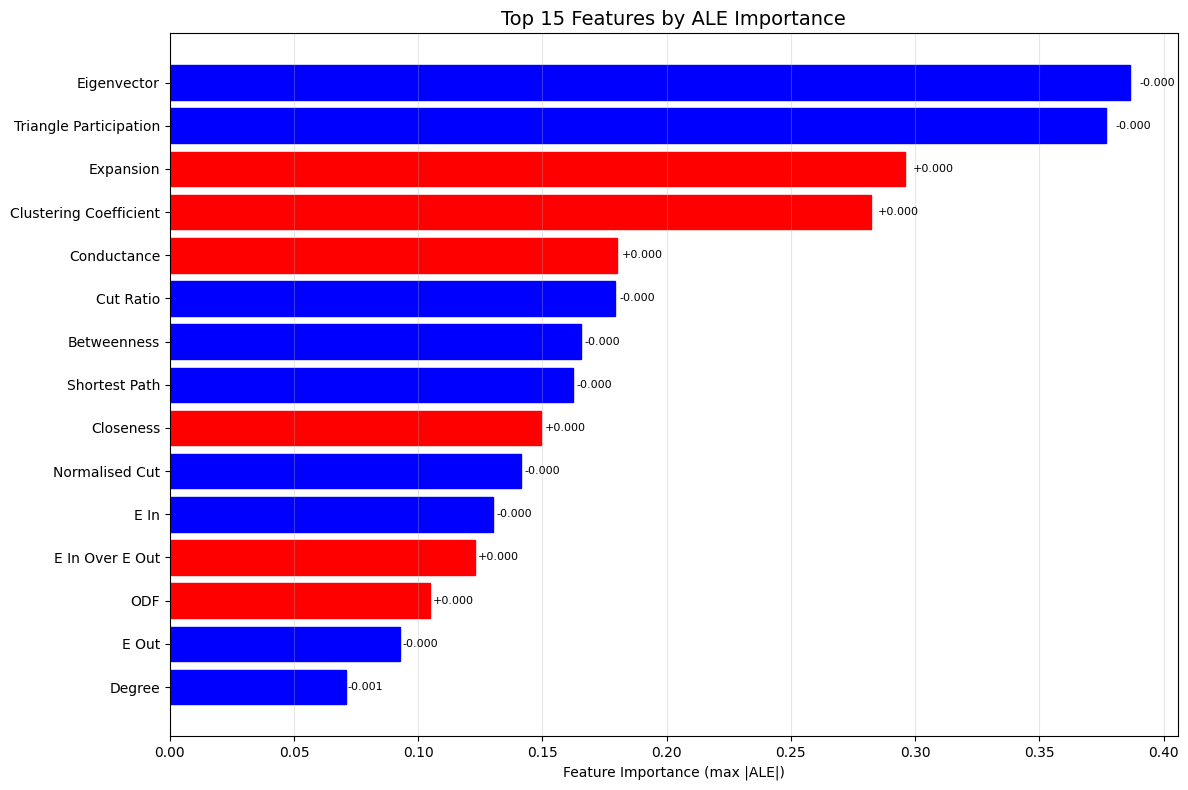


TOP 10 FEATURES BY IMPORTANCE:
                   feature  max_abs_effect   mean_effect  n_graphs
9              Eigenvector        0.386400 -1.514992e-18       120
14  Triangle Participation        0.376950 -3.006854e-19       120
10               Expansion        0.296010  1.503427e-19       120
2   Clustering Coefficient        0.282319  2.002083e-04       120
3              Conductance        0.180040  1.792548e-19       120
4                Cut Ratio        0.179310 -5.782412e-20       120
0              Betweenness        0.165460 -5.435467e-19       120
13           Shortest Path        0.162206 -1.351902e-04       120
1                Closeness        0.149502  6.831020e-05       120
11          Normalised Cut        0.141300 -9.251859e-20       120

All results saved to: LFR_Graph_Data/Community_Data/louvain/results/mu_0_4/ale_average_plots


In [37]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate

# Load your saved results
results_path = f'LFR_Graph_Data/Community_Data/louvain/results/{mu}/all_graphs_results.pkl'
with open(results_path, 'rb') as f:
    all_results = pickle.load(f)

print(f"Loaded {len(all_results)} graphs")
print("Graph names:", list(all_results.keys()))

# Get all unique features across all graphs
all_features = set()
for graph_name, results in all_results.items():
    if 'ale_curves' in results:
        all_features.update(results['ale_curves'].keys())

print(f"\nFound {len(all_features)} unique features:")
for feature in sorted(all_features):
    print(f"  - {feature}")

# Create output directory
output_dir = f'LFR_Graph_Data/Community_Data/louvain/results/{mu}/ale_average_plots'
os.makedirs(output_dir, exist_ok=True)

# Option 1: Plot each feature individually
def plot_all_features_individual(all_results, output_dir, max_features=None):
    """
    Create individual plots for each feature
    """
    features_list = sorted(all_features)
    
    if max_features is not None:
        features_list = features_list[:max_features]
        print(f"Plotting first {max_features} features...")
    
    for i, feature in enumerate(features_list, 1):
        print(f"\n[{i}/{len(features_list)}] Processing: {feature}")
        
        # Check if feature exists in any graph
        feature_exists = False
        for results in all_results.values():
            if 'ale_curves' in results and feature in results['ale_curves']:
                feature_exists = True
                break
        
        if not feature_exists:
            print(f"  Skipping - not found in any graph")
            continue
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        try:
            # Modified version of plot_average_ale_weighted that works without interpolation errors
            plot_average_ale_simple(all_results, feature, ax)
            
            # Save figure
            safe_name = feature.replace('/', '_').replace('\\', '_').replace(':', '_')
            filename = f"ALE_average_{safe_name}.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            print(f"  Saved to {filename}")
            
            # Also save as PDF
            pdf_path = os.path.join(output_dir, f"ALE_average_{safe_name}.pdf")
            plt.savefig(pdf_path, bbox_inches='tight')
            
        except Exception as e:
            print(f"  Error plotting {feature}: {str(e)}")
            plt.close()
            continue
        
        plt.close(fig)

# Option 2: Create grid of plots (multiple features per page)
def plot_features_grid(all_results, output_dir, features_per_page=6):
    """
    Create grid layout with multiple features per page
    """
    features_list = sorted(all_features)
    
    # Calculate number of pages needed
    n_pages = (len(features_list) + features_per_page - 1) // features_per_page
    
    for page in range(n_pages):
        start_idx = page * features_per_page
        end_idx = min(start_idx + features_per_page, len(features_list))
        page_features = features_list[start_idx:end_idx]
        
        # Create subplot grid
        n_cols = 2
        n_rows = (len(page_features) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes]
        
        for idx, (ax, feature) in enumerate(zip(axes, page_features)):
            print(f"Page {page+1}, Plot {idx+1}: {feature}")
            
            try:
                plot_average_ale_simple(all_results, feature, ax)
                ax.set_title(feature, fontsize=10, pad=5)
            except Exception as e:
                ax.text(0.5, 0.5, f"Error\n{str(e)[:30]}...", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{feature} (error)", fontsize=10, color='red')
        
        # Hide unused subplots
        for idx in range(len(page_features), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        
        # Save page
        filename = f"ALE_average_grid_page_{page+1}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        
        print(f"Saved page {page+1}/{n_pages}")
        plt.close()

# Simplified version of plot_average_ale_weighted that's more robust
def plot_average_ale_simple(all_results, feature, ax=None):
    """
    Simple averaging without interpolation - more robust
    """
    # Collect all curves for this feature
    all_curves = []
    graph_names = []
    
    for graph_name, results in all_results.items():
        if 'ale_curves' in results and feature in results['ale_curves']:
            df = results['ale_curves'][feature]
            all_curves.append(df)
            graph_names.append(graph_name)
    
    if not all_curves:
        raise ValueError(f"Feature '{feature}' not found in any graph")
    
    # Find common x-range
    x_min = min([df['x'].min() for df in all_curves])
    x_max = max([df['x'].max() for df in all_curves])
    
    # Create common grid
    common_x = np.linspace(x_min, x_max, 50)
    
    # Interpolate each curve to common grid
    interpolated_values = []
    
    for df in all_curves:
        # Sort by x
        df_sorted = df.sort_values('x')
        x_vals = df_sorted['x'].values
        y_vals = df_sorted['ale_mean'].values
        
        # Remove duplicates in x
        x_vals, unique_idx = np.unique(x_vals, return_index=True)
        y_vals = y_vals[unique_idx]
        
        # Interpolate
        if len(x_vals) > 1:
            f = interpolate.interp1d(x_vals, y_vals, kind='linear', 
                                    bounds_error=False, fill_value='extrapolate')
            y_interp = f(common_x)
            interpolated_values.append(y_interp)
    
    if not interpolated_values:
        raise ValueError("Could not interpolate any curves")
    
    # Convert to array
    interpolated_values = np.array(interpolated_values)
    
    # Calculate statistics
    mean_curve = np.nanmean(interpolated_values, axis=0)
    std_curve = np.nanstd(interpolated_values, axis=0)
    n_graphs = len(interpolated_values)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot average
    ax.plot(common_x, mean_curve, 'b-', linewidth=2, 
            label=f'Average (n={n_graphs})')
    
    # Plot confidence band
    ax.fill_between(common_x, mean_curve - std_curve, mean_curve + std_curve,
                    alpha=0.2, color='b', label='±1 std')
    
    # Plot a few individual curves
    for i in range(min(3, len(all_curves))):
        df = all_curves[i]
        ax.plot(df['x'], df['ale_mean'], 'gray', alpha=0.3, linewidth=0.5)
    
    # Zero reference line
    ax.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Labels
    ax.set_xlabel(f'{feature} value', fontsize=11)
    ax.set_ylabel('ALE effect on P(unstable)', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return ax

# Option 3: Create summary statistics for all features
def create_ale_summary_table(all_results, output_dir):
    """
    Create a CSV with summary statistics for all features
    """
    summary_data = []
    
    for feature in sorted(all_features):
        # Check if feature exists
        has_feature = any('ale_curves' in results and feature in results['ale_curves'] 
                         for results in all_results.values())
        
        if not has_feature:
            continue
        
        # Collect all values
        all_means = []
        for results in all_results.values():
            if 'ale_curves' in results and feature in results['ale_curves']:
                df = results['ale_curves'][feature]
                all_means.extend(df['ale_mean'].values)
        
        if not all_means:
            continue
        
        # Calculate statistics
        all_means = np.array(all_means)
        
        stats = {
            'feature': feature,
            'n_graphs': sum(1 for r in all_results.values() 
                          if 'ale_curves' in r and feature in r['ale_curves']),
            'mean_effect': np.mean(all_means),
            'std_effect': np.std(all_means),
            'max_abs_effect': np.max(np.abs(all_means)),
            'mean_abs_effect': np.mean(np.abs(all_means)),
            'min_effect': np.min(all_means),
            'max_effect': np.max(all_means),
            'q25': np.percentile(all_means, 25),
            'q50': np.percentile(all_means, 50),
            'q75': np.percentile(all_means, 75)
        }
        
        summary_data.append(stats)
    
    # Create DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Sort by importance (max absolute effect)
    if not summary_df.empty:
        summary_df = summary_df.sort_values('max_abs_effect', ascending=False)
        
        # Save to CSV
        csv_path = os.path.join(output_dir, 'ale_features_summary.csv')
        summary_df.to_csv(csv_path, index=False)
        print(f"\nSummary saved to: {csv_path}")
        
        # Create feature importance plot
        fig, ax = plt.subplots(figsize=(12, 8))
        top_n = min(20, len(summary_df))
        
        y_pos = np.arange(top_n)
        bars = ax.barh(y_pos, summary_df['max_abs_effect'].head(top_n))
        
        # Color bars by sign of mean effect
        for i, bar in enumerate(bars):
            mean_effect = summary_df.iloc[i]['mean_effect']
            bar.set_color('red' if mean_effect > 0 else 'blue')
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(summary_df['feature'].head(top_n))
        ax.invert_yaxis()
        ax.set_xlabel('Feature Importance (max |ALE|)')
        ax.set_title(f'Top {top_n} Features by ALE Importance', fontsize=14)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add mean effect as text
        for i, (idx, row) in enumerate(summary_df.head(top_n).iterrows()):
            sign = '+' if row['mean_effect'] > 0 else ''
            ax.text(row['max_abs_effect'] * 1.01, i, 
                   f"{sign}{row['mean_effect']:.3f}", 
                   va='center', fontsize=8)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'feature_importance_ranking.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
    
    return summary_df

print("=" * 60)
print("ALE AVERAGE ANALYSIS FOR ALL FEATURES")
print("=" * 60)

# Method 1: Individual plots
print("\n1. Creating individual plots...")
plot_all_features_individual(all_results, output_dir, max_features=None)

# Method 2: Grid plots
print("\n2. Creating grid plots...")
plot_features_grid(all_results, output_dir, features_per_page=8)

# Method 3: Summary table
print("\n3. Creating summary statistics...")
summary_df = create_ale_summary_table(all_results, output_dir)
    
# Display top features
if summary_df is not None and not summary_df.empty:
    print("\n" + "=" * 60)
    print("TOP 10 FEATURES BY IMPORTANCE:")
    print("=" * 60)
    print(summary_df[['feature', 'max_abs_effect', 'mean_effect', 'n_graphs']].head(10).to_string())
    
    # Also print to file
    with open(os.path.join(output_dir, 'top_features.txt'), 'w') as f:
        f.write("TOP 10 FEATURES BY ALE IMPORTANCE\n")
        f.write("=" * 40 + "\n\n")
        f.write(summary_df[['feature', 'max_abs_effect', 'mean_effect', 'n_graphs']].head(10).to_string())

print(f"\n" + "=" * 60)
print(f"All results saved to: {output_dir}")
print("=" * 60)

In [36]:
!pip install seaborn

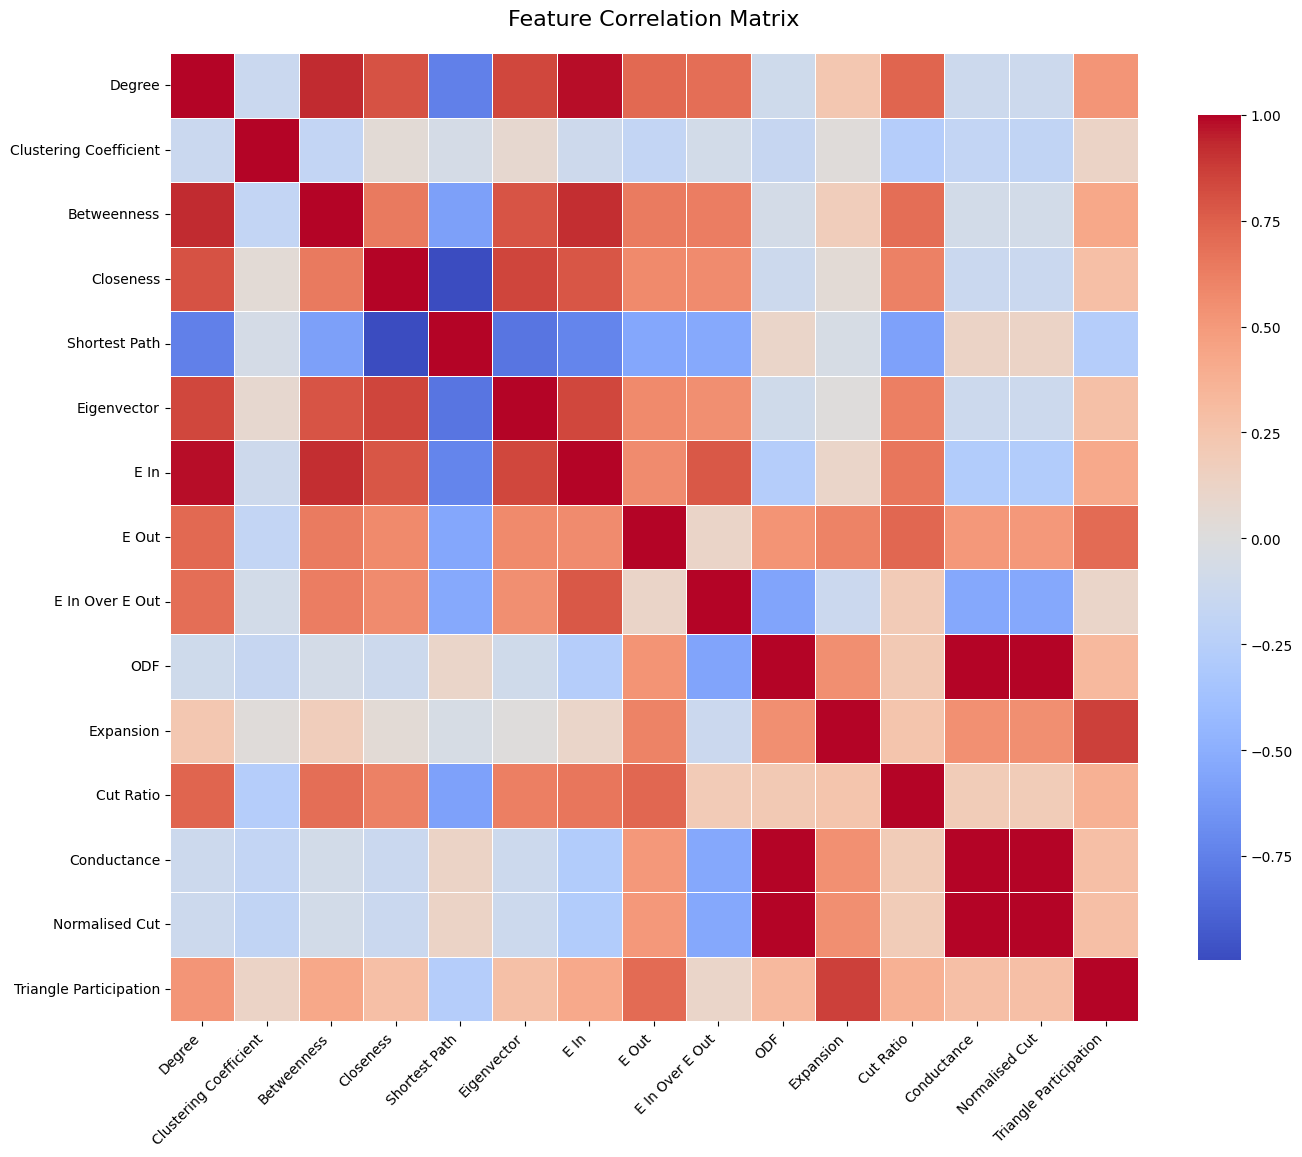

<Figure size 640x480 with 0 Axes>

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load all feature CSVs
feats_folder = 'LFR_Graph_Data/Community_Data/lpa/Node_Features/'
all_dfs = []

for csv_file in os.listdir(feats_folder):
    if csv_file.endswith('_features.csv'):
        df = pd.read_csv(os.path.join(feats_folder, csv_file))
        all_dfs.append(df)

# Combine
features_df = pd.concat(all_dfs, ignore_index=True)

# Calculate correlation
corr_matrix = features_df.select_dtypes(include=[np.number]).corr()

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, 
           linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save
output_dir = 'correlation_results'
os.makedirs(output_dir, exist_ok=True)
corr_matrix.to_csv(os.path.join(output_dir, 'correlation_matrix.csv'))
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')